# Linear Regression and Box Office Gross

Using the IMDB data, construct a feature matrix, and try to predict box office earnings from ratings.

In [1]:
%matplotlib inline

In [2]:
import json

import pandas as pd
import numpy as np

from scipy.sparse import lil_matrix

# Necessary import for linear regression model
from sklearn.linear_model import LinearRegression

# Necessary for KNN Regressor
from sklearn.neighbors import KNeighborsRegressor

# For splitting out training data
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Read in Movies with User Ratings

We don't use user ratings here, but we will focus just on these movies to keep our dataset manageable in size.

In [3]:
known_movies = set()

movie_ids = []

with open("../data/user_ratings.json", "r") as in_file:
    for line in in_file:
        
        this_rating = json.loads(line)
        
        known_movies.add(this_rating["title_id"])


In [4]:
movie_id_to_index = {m:i for i,m in enumerate(movie_ids)}

In [5]:
print("Known Movies:", len(known_movies))


Known Movies: 4465


In [6]:
actor_id_to_name_map = {}     # Map Actor IDs to actor names
actor_id_to_index_map = {}    # Map actor IDs to a unique index of known actors
index_to_actor_ids = []       # Array mapping unique index back to actor ID (invert of actor_id_to_index_map)

index_counter = 0    # Unique actor index; increment for each new actor
known_actors = set()

movie_actor_map = {} # List of all our movies and their actors

test_count = 0
with open("../data/imdb_recent_movies.json", "r") as in_file:
    for line in in_file:
        
        this_movie = json.loads(line)
        
        # Restrict to known movies
        if this_movie["title_id"] not in known_movies:
            continue
            
        # Keep track of all the actors in this movie
        for actor_id,actor_name in zip(this_movie['actor_ids'],this_movie['actor_names']):
            
            # Keep names and IDs
            actor_id_to_name_map[actor_id] = actor_name
            
            # If we've seen this actor before, skip...
            if actor_id in known_actors:
                continue
                
            # ... Otherwise, add to known actor set and create new index for them
            known_actors.add(actor_id)
            actor_id_to_index_map[actor_id] = index_counter
            index_to_actor_ids.append(actor_id)
            index_counter += 1
            
        # Finished with this film
        movie_actor_map[this_movie["title_id"]] = ({
            "movie": this_movie["title_name"],
            "actors": set(this_movie['actor_ids']),
            "genres": this_movie["title_genre"]
        })

In [7]:
print("Known Actors:", len(known_actors))
print("Known Movies:", len(movie_actor_map))

Known Actors: 5224
Known Movies: 4465


## Generate DataFrame using Sparse Matrics

Convert our Actor data into a DataFrame that we can use for analysis.

In [8]:
# With sparse matrix, initialize to size of Movies x Actors of 0s
matrix_sparse = lil_matrix((len(movie_actor_map), len(known_actors)), dtype=bool)

movie_list = list(movie_actor_map.items())

# Update the matrix, movie by movie, setting non-zero values for the appropriate actors
for row,(movie_id,movie) in enumerate(movie_list):   
    for actor_id in movie["actors"]:
        this_index = actor_id_to_index_map[actor_id]
        matrix_sparse[row,this_index] = 1

In [9]:
df = pd.DataFrame.sparse.from_spmatrix(
    matrix_sparse, 
    index=[m_id for m_id,_ in movie_list],
    columns=[index_to_actor_ids[i] for i in range(len(known_actors))]
)
df

,nm0073160,nm0066586,nm0000461,nm0002150,nm0463233,nm0000450,nm0000513,nm0383449,nm0641168,nm0424682,...,nm9636805,nm0620847,nm6203022,nm5457688,nm5219130,nm4592524,nm6710968,nm8076737,nm0157717,nm1523626
tt0118589,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0119273,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0120202,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0120467,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
tt0120630,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9477532,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,0
tt9495224,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
tt9581076,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
tt9636500,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Limit the Feature Matrix to Top-k Actors

Generally, we want the number of rows in our data matrix to be larger than the number of columns. That is, you want more sample than you have features. Here, we address this problem by focusing on the top-k most prolific actors in the dataset and removing films that don't include these top-k actors.

In [10]:
top_k_actors = 512

top_actors = df.sum().sort_values().tail(top_k_actors).index

df = df[top_actors].copy()
df = df[df.sum(axis=1) > 0].copy()

In [11]:
df

,nm0000100,nm0183822,nm5016878,nm2353862,nm1009277,nm0001131,nm1822659,nm0004879,nm0424216,nm0666739,...,nm0000115,nm0000246,nm0000242,nm0001191,nm0425005,nm0005562,nm0000191,nm0268199,nm0000134,nm0000168
tt0120202,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0120630,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0120667,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0120679,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0120681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt8695030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt8772262,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt8976710,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt9243946,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [12]:
print("Movies x Actors dimensionality:", df.shape)

Movies x Actors dimensionality: (2841, 512)


## Join Movie Ratings and Box Office Gross

In [13]:
gross_df = pd.read_csv("../data/actual_gross.csv", index_col="movie_id")

In [14]:
gross_df.describe()

,gross
count,4.002000e+03
mean,8.373434e+07
std,1.786293e+08
min,3.000000e+01
25%,1.713477e+06
50%,1.676972e+07
75%,8.101325e+07
max,2.847380e+09


In [15]:
overlap_movies = set(gross_df.index).intersection(df.index)
print("Overlap:", len(overlap_movies))

Overlap: 2711


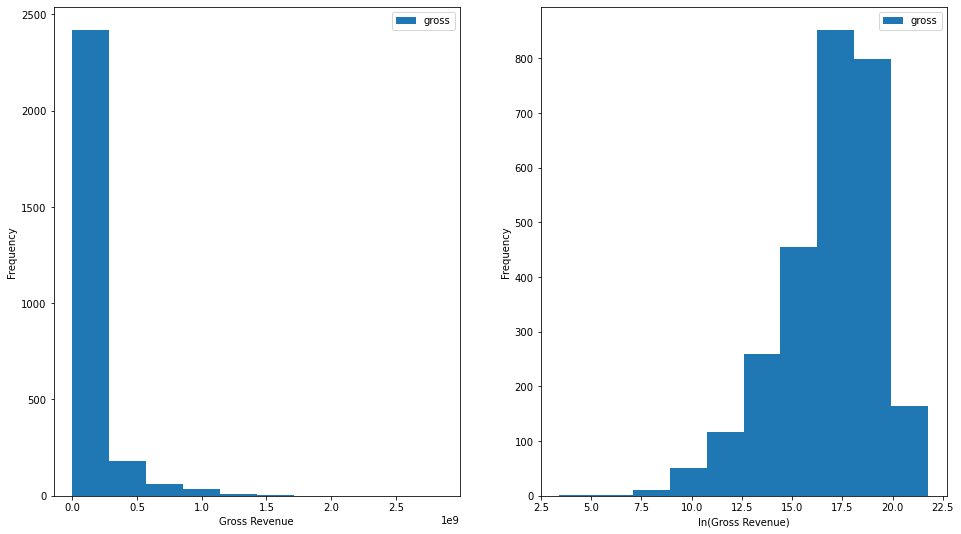

In [16]:
figure = plt.figure(figsize=(16,9))
ax = figure.add_subplot(1,2,1)

# Distribution of Gross Revenue
gross_df.loc[overlap_movies].plot.hist(ax=ax)
ax.set_xlabel("Gross Revenue")

ax = figure.add_subplot(1,2,2)

# Distribution of Gross Revenue in log-transformed space
np.log(gross_df.loc[overlap_movies]).plot.hist(ax=ax)
ax.set_xlabel("ln(Gross Revenue)")

plt.show()

In [17]:
X = df.loc[overlap_movies]

# Note the log transformation here
#. We do this transformation because movie gross
#. is not normally distributed
y = np.log(gross_df.loc[overlap_movies]) 


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=31337)

In [19]:
model = LinearRegression()

# Fit our model on train and test data
model.fit(X_train, y_train)

LinearRegression()

In [20]:
# Inspect the model coefficients
model.coef_

array([[ 2.34697851e+00,  8.80858929e-01,  1.68591282e+00,
        -3.21849861e-01, -6.05605476e-01,  2.39691901e+00,
         2.47295217e+00, -7.15601574e-01, -1.33035802e+00,
        -7.06407904e-01, -6.73534376e-01,  9.91663263e-01,
         2.11561749e+00,  1.04363284e-01, -2.79225657e-01,
         8.88611557e-01,  7.17287891e-01, -4.26865348e-01,
        -4.25618067e-02,  7.08680694e-01,  8.44452654e-01,
        -2.65885138e+00, -2.17134032e+00,  6.38664471e-01,
        -1.48323101e+00,  9.10782963e-01, -8.86000395e-01,
        -2.15255603e+00, -5.48220526e-01, -1.24027068e+00,
         1.05869828e-01,  2.33096854e+00,  1.50733817e+00,
         6.27994512e-01, -1.32186432e+00,  1.17909094e+00,
        -3.37768916e-01, -4.99860029e-01,  1.60409212e+00,
         4.19868081e-01, -1.40586136e+00,  8.97436580e-01,
        -3.22769132e+00, -5.17746436e-01, -3.97260013e-02,
        -1.44863637e+00, -7.56482743e-01,  2.51675297e-01,
         1.56750293e+00,  1.51939589e+00,  1.02784074e+0

In [21]:
# Model intercept, or close to 
# the average of the transformed gross
model.intercept_

array([15.69495412])

In [22]:
# Zip the actors with their model coefficients, so we can inspect actors' roles on gross revenue
actor_weights = list(zip([actor_id_to_name_map[i] for i in X_train.columns], model.coef_[0,:]))

print("Actors with most positive influence on gross:")
for tup in sorted(actor_weights, key=lambda t: t[1], reverse=True)[:10]:
    print(tup)
    
print("\nActors with most negative influence on gross:")
for tup in sorted(actor_weights, key=lambda t: t[1], reverse=True)[-10:]:
    print(tup)

Actors with most positive influence on gross:
('Jason Lee', 3.4032622773493206)
('Rupert Grint', 3.3450674434871086)
('Bill Hader', 3.2736763486145395)
('Tom Hanks', 3.2241697804190808)
('Tobey Maguire', 3.1130334919510148)
('Will Smith', 3.002037998759295)
('T.J. Miller', 2.9608238084799345)
('Michael Keaton', 2.9598477986375253)
('Benedict Cumberbatch', 2.8673377581056703)
('Tobin Bell', 2.8474388183876966)

Actors with most negative influence on gross:
('Thomas Jane', -2.4478803329361556)
('Tom Sizemore', -2.6588513787467085)
('Mark Webber', -2.940567373835491)
('Udo Kier', -2.9415251368281505)
('Michael Angarano', -3.225905200513357)
('Malcolm McDowell', -3.2276913167828414)
('Shea Whigham', -3.503492474753421)
('Kevin Corrigan', -3.518483064494919)
('Wes Bentley', -3.942561670950922)
('Adam Beach', -4.2875070636910895)


In [23]:
predicted_gross = model.predict(X_test)

In [24]:
sqr_errors = []

for predicted,actual in zip(predicted_gross[:,0], y_test["gross"]):
    error = predicted - actual
    sqr_errors.append(error ** 2)

mse = np.mean(sqr_errors)
rmse = mse ** 0.5
print("Mean Square Error: %0.4f" % mse)
print("Root-Mean Square Error: %0.4f" % rmse)

Mean Square Error: 6.1532
Root-Mean Square Error: 2.4806


In [25]:
score_coeff = model.score(X_test, y_test)
print("Coefficient of Determination:", score_coeff)

Coefficient of Determination: 0.03536185052553631


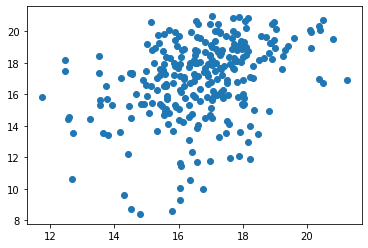

In [26]:
# Distribution of predicted vs. actual gross
plt.scatter(predicted_gross[:,0], y_test["gross"])

## Apply KNN Regressor

Above uses the *linear* regression model, but we can use KNN-regressors here as well.

In [27]:
model = KNeighborsRegressor(n_neighbors=5)

# Fit our model on train and test data
model.fit(X_train, y_train)

KNeighborsRegressor()

In [28]:
predicted_gross = model.predict(X_test)

In [29]:
sqr_errors = []

for predicted,actual in zip(predicted_gross[:,0], y_test["gross"]):
    error = predicted - actual
    sqr_errors.append(error ** 2)

mse = np.mean(sqr_errors)
rmse = mse ** 0.5
print("Mean Square Error: %0.4f" % mse)
print("Root-Mean Square Error: %0.4f" % rmse)

Mean Square Error: 6.5569
Root-Mean Square Error: 2.5606


In [30]:
score_coeff = model.score(X_test, y_test)
print("Coefficient of Determination:", score_coeff)

Coefficient of Determination: -0.027914943009911486
